# Optimization of TLN using differentiable simulation - with mismatch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_formats = ['svg']
# Library imports
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['figure.dpi'] = 200
import matplotlib.pyplot as plt

from jax import config
config.update("jax_enable_x64", True)
from tqdm.auto import tqdm, trange

import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import diffrax as dr
import sympy as sp

from typing import Dict

In [3]:
# Local imports
from ark.cdg.cdg import CDG, CDGNode
from ark.compiler import ArkCompiler
from ark.rewrite import RewriteGen, SympyRewriteGen
from ark.solver import SMTSolver
from ark.specification.cdg_types import NodeType, EdgeType
from ark.validator import ArkValidator
from spec import pulse_sympy
from tln_example import create_tline_branch, IdealV, IdealI, IdealE

## Generate a TLN graph from specification

--- block colors ---
--- line colors ---


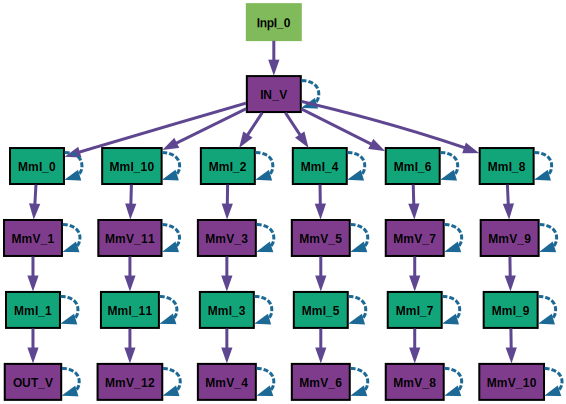

In [4]:
from ark.specification.specification import CDGSpec
from examples.tln.tln_example import make_full_graph


def make_hub_and_spoke(num_spokes: int, spoke_length: int, mismatch=True) -> tuple[CDG, CDGSpec]:
    return make_full_graph(mismatch=mismatch, branch_args_override={
        'line_len': spoke_length,
        'branch_stride': spoke_length,
        'branches_per_node': num_spokes,
        'branch_len': spoke_length - 1,
        'branch_offset': 0,
    })

# graph, spec = make_hub_and_spoke(num_spokes=0, spoke_length=3, mismatch=True)

branch_args = {
    "line_len": 2,
    "branch_stride": 2,
    "branches_per_node": 5,
    "branch_len": 1,
    "branch_offset": 0,
}
graph, spec = make_full_graph(mismatch=True,
                              branch_args_override=branch_args)


from ark.visualize.graphviz_gen import cdg_to_graphviz_display
cdg_to_graphviz_display(cdg_lang=spec, cdg=graph)

Now we have a graph with representing the TLN with certain arguments, and can compile it to SymPy expressions.

In [5]:
compiler = ArkCompiler(rewrite=SympyRewriteGen())
sympy_pairs = compiler.compile_sympy(cdg=graph, cdg_spec=spec, help_fn=[])

In [6]:
sympy_pairs

[(ddt_IN_V,
  -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_20_ws*MmI_2/IN_V_c - MmE_22_ws*MmI_4/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_8/IN_V_c - MmE_28_ws*MmI_10/IN_V_c + MmE_29_wt*(-IN_V*InpI_0_g + InpI_0_fn(time))/IN_V_c),
 (ddt_MmI_0,
  IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 (ddt_MmI_1,
  MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*OUT_V/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 (ddt_MmI_10,
  IN_V*MmE_28_wt/MmI_10_l - MmE_16_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l),
 (ddt_MmI_11,
  MmE_17_wt*MmV_11/MmI_11_l - MmE_18_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l),
 (ddt_MmI_2,
  IN_V*MmE_20_wt/MmI_2_l - MmE_4_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 (ddt_MmI_3,
  MmE_5_wt*MmV_3/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 (ddt_MmI_4,
  IN_V*MmE_22_wt/MmI_4_l - MmE_7_ws*MmV_5/MmI_4_l - MmI_4*MmI_4_r/MmI_4_l),
 (ddt_MmI_5,
  MmE_8_wt*MmV_5/MmI_5_l - MmE_9_ws*MmV_6/MmI_5_l - MmI_5*MmI_5_r/MmI_5_l),
 (ddt_MmI_6,
  IN_V*MmE_24_wt/M

We can now convert these into a set of differential equations, using some amount of parsing.

In [7]:
def collapse_derivative(pair: tuple[sp.Symbol, sp.Expr]) -> sp.Eq:
    """Turns tuple of derivative + sympy expression into a single sympy equation."""
    if (var_name := pair[0].name).startswith('ddt_'):
        symbol = sp.symbols(var_name[4:])
        equation = sp.Eq(sp.Derivative(symbol, sp.symbols('time')), pair[1])
        return equation.subs(sp.symbols('time'), sp.symbols('t'))
    else:
        raise ValueError("Not a derivative expression.")
sympy_eqs = [collapse_derivative(pair) for pair in sympy_pairs]
sympy_eqs

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_20_ws*MmI_2/IN_V_c - MmE_22_ws*MmI_4/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_8/IN_V_c - MmE_28_ws*MmI_10/IN_V_c + MmE_29_wt*(-IN_V*InpI_0_g + InpI_0_fn(t))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*OUT_V/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_10, t), IN_V*MmE_28_wt/MmI_10_l - MmE_16_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l),
 Eq(Derivative(MmI_11, t), MmE_17_wt*MmV_11/MmI_11_l - MmE_18_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l),
 Eq(Derivative(MmI_2, t), IN_V*MmE_20_wt/MmI_2_l - MmE_4_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), MmE_5_wt*MmV_3/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(Derivative(MmI_4, t), IN_V*MmE_22_wt/MmI_4_l - MmE_7_ws*MmV_5/MmI_4_l - MmI_4*MmI_4_r/MmI_4_l),
 Eq(Derivative(MmI_5, t), MmE_8_wt*

Now we need to substitute the forcing function `InpI_0_fn` into a pulse function (a piecewise function defined in SymPy).

In [8]:
t = sp.symbols('t')
InpI_0_fn = sp.Function('InpI_0_fn')
replaced_function = sympy_eqs[0].subs(InpI_0_fn(t), pulse_sympy(t))
replaced_function

Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_20_ws*MmI_2/IN_V_c - MmE_22_ws*MmI_4/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_8/IN_V_c - MmE_28_ws*MmI_10/IN_V_c + MmE_29_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c)

In [9]:
sympy_eqs_expanded = [replaced_function if i == 0 else f for i, f in enumerate(sympy_eqs)]

In [10]:
sympy_eqs_expanded

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_20_ws*MmI_2/IN_V_c - MmE_22_ws*MmI_4/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_8/IN_V_c - MmE_28_ws*MmI_10/IN_V_c + MmE_29_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*OUT_V/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_10, t), IN_V*MmE_28_wt/MmI_10_l - MmE_16_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l),
 Eq(Derivative(MmI_11, t), MmE_17_wt*MmV_11/MmI_11_l - MmE_18_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l),
 Eq(Derivative(MmI_2, t), IN_V*MmE_20_wt/MmI_2_l - MmE_4_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), MmE_5_wt*MmV_3/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(

### Add non-linearities to each equation

In [11]:
# Wrap all multiply and divides in a non-linear function
non_linear_scale = 5e-8
non_linearity = lambda x: sp.tanh(non_linear_scale * x) / non_linear_scale
non_linearity = lambda x: x
def pre_transform(expr: sp.Expr):
    match expr:
        case sp.Mul(args=(*_, sp.Pow(args=(_, -1)))):
            print(f'Found mul! {expr}')
            return non_linearity(expr)
        case sp.Symbol() | sp.Number() | sp.Integer() | sp.Tuple():
            return expr
    new_args = [
        pre_transform(arg)
        for arg in expr.args
    ]
    new_expr = expr.func(*new_args)
    return new_expr
pre_transform(sympy_eqs_expanded[1])

# Hmm, that works, but maybe it's better to wrap the whole expression in a tanh instead

Found mul! IN_V*MmE_0_wt/MmI_0_l
Found mul! -MmE_1_ws*MmV_1/MmI_0_l
Found mul! -MmI_0*MmI_0_r/MmI_0_l


Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l)

In [12]:
def rhs_non_linearity(eq: sp.Eq):
    assert isinstance(eq, sp.Eq)
    return sp.Eq(eq.lhs, non_linearity(eq.rhs))

sympy_eqs_complete = [rhs_non_linearity(eq) if i != 0 else eq for i, eq in enumerate(sympy_eqs_expanded)]
# sympy_eqs_complete = sympy_eqs_expanded
sympy_eqs_complete

[Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_20_ws*MmI_2/IN_V_c - MmE_22_ws*MmI_4/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_8/IN_V_c - MmE_28_ws*MmI_10/IN_V_c + MmE_29_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c),
 Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l),
 Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*OUT_V/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l),
 Eq(Derivative(MmI_10, t), IN_V*MmE_28_wt/MmI_10_l - MmE_16_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l),
 Eq(Derivative(MmI_11, t), MmE_17_wt*MmV_11/MmI_11_l - MmE_18_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l),
 Eq(Derivative(MmI_2, t), IN_V*MmE_20_wt/MmI_2_l - MmE_4_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l),
 Eq(Derivative(MmI_3, t), MmE_5_wt*MmV_3/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l),
 Eq(

In [11]:
sympy_eqs_complete = sympy_eqs_expanded

In [12]:
# Find all the LHS variables in the set of equations
lhs_vars = [list(eq.lhs.free_symbols)[0] for eq in sympy_eqs_complete]
lhs_vars

[IN_V,
 MmI_0,
 MmI_1,
 MmI_10,
 MmI_11,
 MmI_2,
 MmI_3,
 MmI_4,
 MmI_5,
 MmI_6,
 MmI_7,
 MmI_8,
 MmI_9,
 MmV_1,
 MmV_10,
 MmV_11,
 MmV_12,
 MmV_3,
 MmV_4,
 MmV_5,
 MmV_6,
 MmV_7,
 MmV_8,
 MmV_9,
 OUT_V]

In [13]:
# Figure out which parameters are necessary to evaluate the equations
param_vars = [eq.free_symbols - set(lhs_vars) for eq in sympy_eqs_complete]
all_param_vars = set().union(*param_vars)
all_param_vars.remove(sp.symbols('t'))
del param_vars
print(f'All parameters:\n{", ".join(map(str, all_param_vars))}')

All parameters:
MmE_28_ws, MmV_12_c, MmE_5_ws, MmV_7_g, MmV_6_c, MmV_8_g, MmV_1_c, MmE_8_wt, MmE_16_wt, MmE_7_ws, IN_V_g, MmE_11_wt, MmV_4_c, IN_V_c, MmE_24_ws, MmE_20_ws, MmE_26_ws, MmV_12_g, MmI_2_l, MmI_3_r, MmE_13_ws, MmV_4_g, MmI_9_l, MmV_10_c, MmV_10_g, MmI_3_l, MmE_7_wt, MmE_1_wt, MmI_0_l, MmV_3_g, MmE_8_ws, OUT_V_g, MmE_17_ws, MmE_24_wt, MmV_8_c, MmV_9_c, MmV_5_g, MmE_4_wt, MmE_3_ws, MmE_9_ws, MmV_7_c, MmE_15_ws, MmV_11_g, MmE_18_ws, MmE_9_wt, MmI_0_r, MmE_4_ws, MmI_5_l, MmI_9_r, MmI_11_l, MmE_12_wt, MmI_4_r, MmE_22_ws, MmE_14_wt, MmE_11_ws, MmI_7_r, MmI_7_l, MmV_5_c, MmE_29_wt, MmE_6_ws, MmE_2_wt, MmE_6_wt, MmE_13_wt, MmE_1_ws, MmE_3_wt, MmE_26_wt, MmV_11_c, MmE_2_ws, MmI_2_r, MmE_10_ws, OUT_V_c, MmE_0_ws, MmI_10_r, MmE_5_wt, MmE_17_wt, MmE_20_wt, MmV_9_g, MmV_1_g, MmE_0_wt, MmE_15_wt, MmE_14_ws, MmI_8_l, MmE_10_wt, MmE_16_ws, MmV_6_g, MmE_12_ws, MmI_6_l, MmE_22_wt, MmI_11_r, MmE_28_wt, MmI_5_r, MmE_18_wt, MmV_3_c, MmI_8_r, MmI_10_l, MmI_6_r, MmI_4_l, MmI_1_l, MmI_1_r, InpI_0_

In [14]:
# Now we gather the parameters necessary from the respective nodes in the graph
def get_param_from_dict(param_name: str) -> float:
    element_name = '_'.join(param_name.split('_')[:-1])
    param_name = param_name.split('_')[-1]
    return graph_param_dict[element_name][param_name]

# Collect all node parameters into a dictionary with dictionary values
node_param_dict = {node.name: node.attrs for node in graph.nodes}
edge_param_dict = {edge.name: edge.attrs for edge in graph.edges}
graph_param_dict = node_param_dict | edge_param_dict

# Gather all necessary parameters in a flat dictionary
param_dict = {k: get_param_from_dict(k.name) for k in all_param_vars}
param_dict[sp.symbols('OUT_V_g')] = 0.0
param_dict

{MmE_28_ws: 1.0,
 MmV_12_c: 1e-09,
 MmE_5_ws: 1.0,
 MmV_7_g: 0.0,
 MmV_6_c: 1e-09,
 MmV_8_g: 0.0,
 MmV_1_c: 1e-09,
 MmE_8_wt: 1.0,
 MmE_16_wt: 1.0,
 MmE_7_ws: 1.0,
 IN_V_g: 0.0,
 MmE_11_wt: 1.0,
 MmV_4_c: 1e-09,
 IN_V_c: 1e-09,
 MmE_24_ws: 1.0,
 MmE_20_ws: 1.0,
 MmE_26_ws: 1.0,
 MmV_12_g: 0.0,
 MmI_2_l: 1e-09,
 MmI_3_r: 0.0,
 MmE_13_ws: 1.0,
 MmV_4_g: 0.0,
 MmI_9_l: 1e-09,
 MmV_10_c: 1e-09,
 MmV_10_g: 0.0,
 MmI_3_l: 1e-09,
 MmE_7_wt: 1.0,
 MmE_1_wt: 1.0,
 MmI_0_l: 1e-09,
 MmV_3_g: 0.0,
 MmE_8_ws: 1.0,
 OUT_V_g: 0.0,
 MmE_17_ws: 1.0,
 MmE_24_wt: 1.0,
 MmV_8_c: 1e-09,
 MmV_9_c: 1e-09,
 MmV_5_g: 0.0,
 MmE_4_wt: 1.0,
 MmE_3_ws: 1.0,
 MmE_9_ws: 1.0,
 MmV_7_c: 1e-09,
 MmE_15_ws: 1.0,
 MmV_11_g: 0.0,
 MmE_18_ws: 1.0,
 MmE_9_wt: 1.0,
 MmI_0_r: 0.0,
 MmE_4_ws: 1.0,
 MmI_5_l: 1e-09,
 MmI_9_r: 0.0,
 MmI_11_l: 1e-09,
 MmE_12_wt: 1.0,
 MmI_4_r: 0.0,
 MmE_22_ws: 1.0,
 MmE_14_wt: 1.0,
 MmE_11_ws: 1.0,
 MmI_7_r: 0.0,
 MmI_7_l: 1e-09,
 MmV_5_c: 1e-09,
 MmE_29_wt: 1.0,
 MmE_6_ws: 1.0,
 MmE_2_wt: 1.0,
 M

In [15]:
# Gather initial values for the LHS variables
# TODO(marcelroed): Currently all at zero -- should this change?
lhs_init_dict = {k: 0.0 for k in lhs_vars}

### Reminder of relevant variables

In [16]:
for eq in sympy_eqs_complete:
    print(eq)
    display(eq)  # List of all equations defining the system
display(lhs_vars)  # Names of all left-hand side variables
display(param_dict)  # Mapping of all parameters to be simulated -- are what we want sensitivities for

Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_20_ws*MmI_2/IN_V_c - MmE_22_ws*MmI_4/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_8/IN_V_c - MmE_28_ws*MmI_10/IN_V_c + MmE_29_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c)


Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_20_ws*MmI_2/IN_V_c - MmE_22_ws*MmI_4/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_8/IN_V_c - MmE_28_ws*MmI_10/IN_V_c + MmE_29_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c)

Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l)


Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l)

Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*OUT_V/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l)


Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*OUT_V/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l)

Eq(Derivative(MmI_10, t), IN_V*MmE_28_wt/MmI_10_l - MmE_16_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l)


Eq(Derivative(MmI_10, t), IN_V*MmE_28_wt/MmI_10_l - MmE_16_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l)

Eq(Derivative(MmI_11, t), MmE_17_wt*MmV_11/MmI_11_l - MmE_18_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l)


Eq(Derivative(MmI_11, t), MmE_17_wt*MmV_11/MmI_11_l - MmE_18_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l)

Eq(Derivative(MmI_2, t), IN_V*MmE_20_wt/MmI_2_l - MmE_4_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l)


Eq(Derivative(MmI_2, t), IN_V*MmE_20_wt/MmI_2_l - MmE_4_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l)

Eq(Derivative(MmI_3, t), MmE_5_wt*MmV_3/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l)


Eq(Derivative(MmI_3, t), MmE_5_wt*MmV_3/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l)

Eq(Derivative(MmI_4, t), IN_V*MmE_22_wt/MmI_4_l - MmE_7_ws*MmV_5/MmI_4_l - MmI_4*MmI_4_r/MmI_4_l)


Eq(Derivative(MmI_4, t), IN_V*MmE_22_wt/MmI_4_l - MmE_7_ws*MmV_5/MmI_4_l - MmI_4*MmI_4_r/MmI_4_l)

Eq(Derivative(MmI_5, t), MmE_8_wt*MmV_5/MmI_5_l - MmE_9_ws*MmV_6/MmI_5_l - MmI_5*MmI_5_r/MmI_5_l)


Eq(Derivative(MmI_5, t), MmE_8_wt*MmV_5/MmI_5_l - MmE_9_ws*MmV_6/MmI_5_l - MmI_5*MmI_5_r/MmI_5_l)

Eq(Derivative(MmI_6, t), IN_V*MmE_24_wt/MmI_6_l - MmE_10_ws*MmV_7/MmI_6_l - MmI_6*MmI_6_r/MmI_6_l)


Eq(Derivative(MmI_6, t), IN_V*MmE_24_wt/MmI_6_l - MmE_10_ws*MmV_7/MmI_6_l - MmI_6*MmI_6_r/MmI_6_l)

Eq(Derivative(MmI_7, t), MmE_11_wt*MmV_7/MmI_7_l - MmE_12_ws*MmV_8/MmI_7_l - MmI_7*MmI_7_r/MmI_7_l)


Eq(Derivative(MmI_7, t), MmE_11_wt*MmV_7/MmI_7_l - MmE_12_ws*MmV_8/MmI_7_l - MmI_7*MmI_7_r/MmI_7_l)

Eq(Derivative(MmI_8, t), IN_V*MmE_26_wt/MmI_8_l - MmE_13_ws*MmV_9/MmI_8_l - MmI_8*MmI_8_r/MmI_8_l)


Eq(Derivative(MmI_8, t), IN_V*MmE_26_wt/MmI_8_l - MmE_13_ws*MmV_9/MmI_8_l - MmI_8*MmI_8_r/MmI_8_l)

Eq(Derivative(MmI_9, t), MmE_14_wt*MmV_9/MmI_9_l - MmE_15_ws*MmV_10/MmI_9_l - MmI_9*MmI_9_r/MmI_9_l)


Eq(Derivative(MmI_9, t), MmE_14_wt*MmV_9/MmI_9_l - MmE_15_ws*MmV_10/MmI_9_l - MmI_9*MmI_9_r/MmI_9_l)

Eq(Derivative(MmV_1, t), MmE_1_wt*MmI_0/MmV_1_c - MmE_2_ws*MmI_1/MmV_1_c - MmV_1*MmV_1_g/MmV_1_c)


Eq(Derivative(MmV_1, t), MmE_1_wt*MmI_0/MmV_1_c - MmE_2_ws*MmI_1/MmV_1_c - MmV_1*MmV_1_g/MmV_1_c)

Eq(Derivative(MmV_10, t), MmE_15_wt*MmI_9/MmV_10_c - MmV_10*MmV_10_g/MmV_10_c)


Eq(Derivative(MmV_10, t), MmE_15_wt*MmI_9/MmV_10_c - MmV_10*MmV_10_g/MmV_10_c)

Eq(Derivative(MmV_11, t), MmE_16_wt*MmI_10/MmV_11_c - MmE_17_ws*MmI_11/MmV_11_c - MmV_11*MmV_11_g/MmV_11_c)


Eq(Derivative(MmV_11, t), MmE_16_wt*MmI_10/MmV_11_c - MmE_17_ws*MmI_11/MmV_11_c - MmV_11*MmV_11_g/MmV_11_c)

Eq(Derivative(MmV_12, t), MmE_18_wt*MmI_11/MmV_12_c - MmV_12*MmV_12_g/MmV_12_c)


Eq(Derivative(MmV_12, t), MmE_18_wt*MmI_11/MmV_12_c - MmV_12*MmV_12_g/MmV_12_c)

Eq(Derivative(MmV_3, t), MmE_4_wt*MmI_2/MmV_3_c - MmE_5_ws*MmI_3/MmV_3_c - MmV_3*MmV_3_g/MmV_3_c)


Eq(Derivative(MmV_3, t), MmE_4_wt*MmI_2/MmV_3_c - MmE_5_ws*MmI_3/MmV_3_c - MmV_3*MmV_3_g/MmV_3_c)

Eq(Derivative(MmV_4, t), MmE_6_wt*MmI_3/MmV_4_c - MmV_4*MmV_4_g/MmV_4_c)


Eq(Derivative(MmV_4, t), MmE_6_wt*MmI_3/MmV_4_c - MmV_4*MmV_4_g/MmV_4_c)

Eq(Derivative(MmV_5, t), MmE_7_wt*MmI_4/MmV_5_c - MmE_8_ws*MmI_5/MmV_5_c - MmV_5*MmV_5_g/MmV_5_c)


Eq(Derivative(MmV_5, t), MmE_7_wt*MmI_4/MmV_5_c - MmE_8_ws*MmI_5/MmV_5_c - MmV_5*MmV_5_g/MmV_5_c)

Eq(Derivative(MmV_6, t), MmE_9_wt*MmI_5/MmV_6_c - MmV_6*MmV_6_g/MmV_6_c)


Eq(Derivative(MmV_6, t), MmE_9_wt*MmI_5/MmV_6_c - MmV_6*MmV_6_g/MmV_6_c)

Eq(Derivative(MmV_7, t), MmE_10_wt*MmI_6/MmV_7_c - MmE_11_ws*MmI_7/MmV_7_c - MmV_7*MmV_7_g/MmV_7_c)


Eq(Derivative(MmV_7, t), MmE_10_wt*MmI_6/MmV_7_c - MmE_11_ws*MmI_7/MmV_7_c - MmV_7*MmV_7_g/MmV_7_c)

Eq(Derivative(MmV_8, t), MmE_12_wt*MmI_7/MmV_8_c - MmV_8*MmV_8_g/MmV_8_c)


Eq(Derivative(MmV_8, t), MmE_12_wt*MmI_7/MmV_8_c - MmV_8*MmV_8_g/MmV_8_c)

Eq(Derivative(MmV_9, t), MmE_13_wt*MmI_8/MmV_9_c - MmE_14_ws*MmI_9/MmV_9_c - MmV_9*MmV_9_g/MmV_9_c)


Eq(Derivative(MmV_9, t), MmE_13_wt*MmI_8/MmV_9_c - MmE_14_ws*MmI_9/MmV_9_c - MmV_9*MmV_9_g/MmV_9_c)

Eq(Derivative(OUT_V, t), MmE_3_wt*MmI_1/OUT_V_c - OUT_V*OUT_V_g/OUT_V_c)


Eq(Derivative(OUT_V, t), MmE_3_wt*MmI_1/OUT_V_c - OUT_V*OUT_V_g/OUT_V_c)

[IN_V,
 MmI_0,
 MmI_1,
 MmI_10,
 MmI_11,
 MmI_2,
 MmI_3,
 MmI_4,
 MmI_5,
 MmI_6,
 MmI_7,
 MmI_8,
 MmI_9,
 MmV_1,
 MmV_10,
 MmV_11,
 MmV_12,
 MmV_3,
 MmV_4,
 MmV_5,
 MmV_6,
 MmV_7,
 MmV_8,
 MmV_9,
 OUT_V]

{MmE_28_ws: 1.0,
 MmV_12_c: 1e-09,
 MmE_5_ws: 1.0,
 MmV_7_g: 0.0,
 MmV_6_c: 1e-09,
 MmV_8_g: 0.0,
 MmV_1_c: 1e-09,
 MmE_8_wt: 1.0,
 MmE_16_wt: 1.0,
 MmE_7_ws: 1.0,
 IN_V_g: 0.0,
 MmE_11_wt: 1.0,
 MmV_4_c: 1e-09,
 IN_V_c: 1e-09,
 MmE_24_ws: 1.0,
 MmE_20_ws: 1.0,
 MmE_26_ws: 1.0,
 MmV_12_g: 0.0,
 MmI_2_l: 1e-09,
 MmI_3_r: 0.0,
 MmE_13_ws: 1.0,
 MmV_4_g: 0.0,
 MmI_9_l: 1e-09,
 MmV_10_c: 1e-09,
 MmV_10_g: 0.0,
 MmI_3_l: 1e-09,
 MmE_7_wt: 1.0,
 MmE_1_wt: 1.0,
 MmI_0_l: 1e-09,
 MmV_3_g: 0.0,
 MmE_8_ws: 1.0,
 OUT_V_g: 0.0,
 MmE_17_ws: 1.0,
 MmE_24_wt: 1.0,
 MmV_8_c: 1e-09,
 MmV_9_c: 1e-09,
 MmV_5_g: 0.0,
 MmE_4_wt: 1.0,
 MmE_3_ws: 1.0,
 MmE_9_ws: 1.0,
 MmV_7_c: 1e-09,
 MmE_15_ws: 1.0,
 MmV_11_g: 0.0,
 MmE_18_ws: 1.0,
 MmE_9_wt: 1.0,
 MmI_0_r: 0.0,
 MmE_4_ws: 1.0,
 MmI_5_l: 1e-09,
 MmI_9_r: 0.0,
 MmI_11_l: 1e-09,
 MmE_12_wt: 1.0,
 MmI_4_r: 0.0,
 MmE_22_ws: 1.0,
 MmE_14_wt: 1.0,
 MmE_11_ws: 1.0,
 MmI_7_r: 0.0,
 MmI_7_l: 1e-09,
 MmV_5_c: 1e-09,
 MmE_29_wt: 1.0,
 MmE_6_ws: 1.0,
 MmE_2_wt: 1.0,
 M

## Defining the DiffEQ solve function


In [17]:
def keys_to_str(d: dict) -> dict:
    return {str(k): v for k, v in d.items()}
keys_to_str(lhs_init_dict)

{'IN_V': 0.0,
 'MmI_0': 0.0,
 'MmI_1': 0.0,
 'MmI_10': 0.0,
 'MmI_11': 0.0,
 'MmI_2': 0.0,
 'MmI_3': 0.0,
 'MmI_4': 0.0,
 'MmI_5': 0.0,
 'MmI_6': 0.0,
 'MmI_7': 0.0,
 'MmI_8': 0.0,
 'MmI_9': 0.0,
 'MmV_1': 0.0,
 'MmV_10': 0.0,
 'MmV_11': 0.0,
 'MmV_12': 0.0,
 'MmV_3': 0.0,
 'MmV_4': 0.0,
 'MmV_5': 0.0,
 'MmV_6': 0.0,
 'MmV_7': 0.0,
 'MmV_8': 0.0,
 'MmV_9': 0.0,
 'OUT_V': 0.0}

In [20]:
def lambdify_evaluate(expr: sp.Expr, vec_values: dict, parameter_values: dict) -> jax.Array:
    """Lambdifies a sympy equation and evaluates it with the given parameter values."""
    # Lambdify the equation
    free_symbols = list(expr.free_symbols)
    lambdified_eq = sp.lambdify(free_symbols, expr=expr, modules='jax')
    # Evaluate the equation
    evaluation_parameters = {k: parameter_values[k] if k in parameter_values else vec_values[k] for k in map(str, free_symbols)}
    return lambdified_eq(**evaluation_parameters)

# @eqx.filter_jit
def solve_system(initial_values: Dict[str, float], parameter_values: Dict[str, float], saveat: dr.SaveAt) -> dr.Solution:
    print('Solving')
    initial_y = jnp.array([initial_values[k] for k in map(str, lhs_vars)])
    def f(t: float, y: jax.Array, args: jax.Array) -> jax.Array:
        # Loop through and lambdify all equations
        vec_values = {k: y[i] for i, k in enumerate(map(str, lhs_vars))}
        args_with_t = {**args, 't': t}
        return jnp.array([lambdify_evaluate(expr=eq.rhs, vec_values=vec_values, parameter_values=args_with_t) for eq in sympy_eqs_complete])
    
    print(f(1e-8, initial_y, parameter_values))
    
    term = dr.ODETerm(f)
    solver = dr.Heun()
    # # adjoint = dr.BacksolveAdjoint(solver=solver, adjoint=dr.BacksolveAdjoint(solver=solver)) if (saveat.subs.steps is False and saveat.dense is False) else dr.RecursiveCheckpointAdjoint()
    adjoint = dr.DirectAdjoint()
    # adjoint = None
    print(f'{adjoint=}')
    max_steps = 100_000
    t1 = 75e-9
    dt0 = t1 / max_steps
    system_solution = dr.diffeqsolve(terms=term, solver=solver, t0=0.0, t1=75e-9, dt0=dt0, y0=initial_y,
                                     args=parameter_values, saveat=saveat, max_steps=100_000,
                                     adjoint=adjoint
                                     )
    return system_solution

print('Running')
solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=keys_to_str(param_dict), saveat=dr.SaveAt(steps=True))

Running
Solving
[1.e+09 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
adjoint=DirectAdjoint()


Solution(
  t0=f64[],
  t1=f64[],
  ts=f64[100000],
  ys=f64[100000,25],
  interpolation=None,
  stats={
    'max_steps':
    100000,
    'num_accepted_steps':
    i64[],
    'num_rejected_steps':
    i64[],
    'num_steps':
    i64[]
  },
  result=i64[],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

{'max_steps': 100000,
 'num_accepted_steps': Array(99867, dtype=int64, weak_type=True),
 'num_rejected_steps': Array(0, dtype=int64, weak_type=True),
 'num_steps': Array(99867, dtype=int64, weak_type=True)}

Finished getting solution!


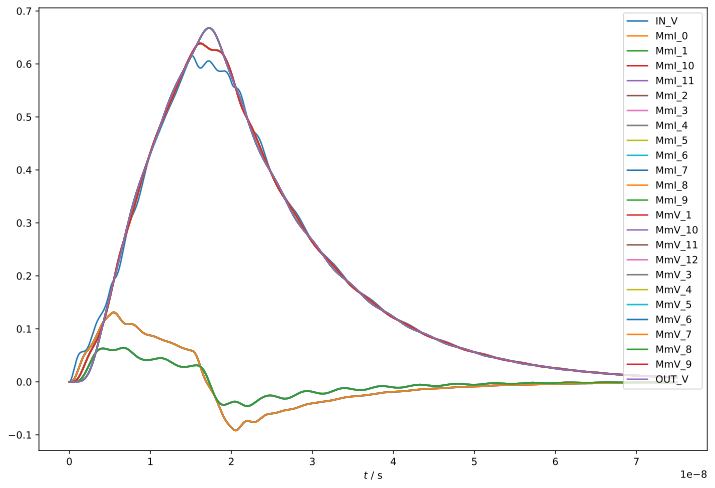

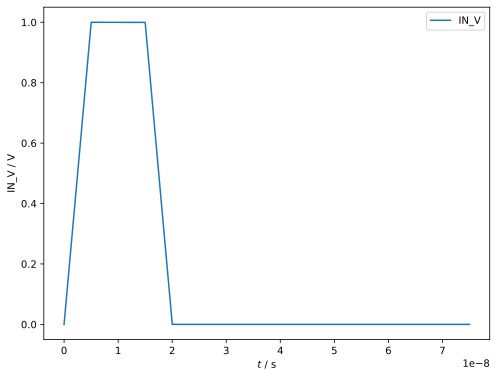

In [21]:
display(solution)
display(solution.stats)
jax.block_until_ready(solution.ys)
print('Finished getting solution!')
plt.plot(solution.ts, solution.ys[:, :])
plt.legend(lhs_vars)
plt.xlabel('$t$ / s')
plt.gcf().set_size_inches(12, 8)
plt.savefig('full_solution.png', dpi=300)
plt.show()
plt.plot(solution.ts, sp.lambdify(sp.symbols('t'), pulse_sympy(sp.symbols('t')))(solution.ts))
plt.legend(['IN_V'], loc='upper right')
plt.xlabel('$t$ / s')
plt.ylabel('IN_V / V')
plt.gcf().set_size_inches(8, 6)
plt.savefig('forcing_function.png', dpi=300)
plt.show()

In [21]:
solution.ts

Array([7.50e-13, 1.50e-12, 2.25e-12, ...,      inf,      inf,      inf],      dtype=float64, weak_type=True)

In [24]:
for eq in sympy_eqs_complete:
    display(eq)

Eq(Derivative(IN_V, t), -IN_V*IN_V_g/IN_V_c - MmE_0_ws*MmI_0/IN_V_c - MmE_20_ws*MmI_2/IN_V_c - MmE_22_ws*MmI_4/IN_V_c - MmE_24_ws*MmI_6/IN_V_c - MmE_26_ws*MmI_8/IN_V_c - MmE_28_ws*MmI_10/IN_V_c + MmE_29_wt*(-IN_V*InpI_0_g + Piecewise((200000000.0*(Mod(t, 1)), Mod(t, 1) < 5.0e-9), (1, Mod(t, 1) < 1.5e-8), (4.0 - 200000000.0*Mod(t, 1), Mod(t, 1) < 2.0e-8), (0, True)))/IN_V_c)

Eq(Derivative(MmI_0, t), IN_V*MmE_0_wt/MmI_0_l - MmE_1_ws*MmV_1/MmI_0_l - MmI_0*MmI_0_r/MmI_0_l)

Eq(Derivative(MmI_1, t), MmE_2_wt*MmV_1/MmI_1_l - MmE_3_ws*OUT_V/MmI_1_l - MmI_1*MmI_1_r/MmI_1_l)

Eq(Derivative(MmI_10, t), IN_V*MmE_28_wt/MmI_10_l - MmE_16_ws*MmV_11/MmI_10_l - MmI_10*MmI_10_r/MmI_10_l)

Eq(Derivative(MmI_11, t), MmE_17_wt*MmV_11/MmI_11_l - MmE_18_ws*MmV_12/MmI_11_l - MmI_11*MmI_11_r/MmI_11_l)

Eq(Derivative(MmI_2, t), IN_V*MmE_20_wt/MmI_2_l - MmE_4_ws*MmV_3/MmI_2_l - MmI_2*MmI_2_r/MmI_2_l)

Eq(Derivative(MmI_3, t), MmE_5_wt*MmV_3/MmI_3_l - MmE_6_ws*MmV_4/MmI_3_l - MmI_3*MmI_3_r/MmI_3_l)

Eq(Derivative(MmI_4, t), IN_V*MmE_22_wt/MmI_4_l - MmE_7_ws*MmV_5/MmI_4_l - MmI_4*MmI_4_r/MmI_4_l)

Eq(Derivative(MmI_5, t), MmE_8_wt*MmV_5/MmI_5_l - MmE_9_ws*MmV_6/MmI_5_l - MmI_5*MmI_5_r/MmI_5_l)

Eq(Derivative(MmI_6, t), IN_V*MmE_24_wt/MmI_6_l - MmE_10_ws*MmV_7/MmI_6_l - MmI_6*MmI_6_r/MmI_6_l)

Eq(Derivative(MmI_7, t), MmE_11_wt*MmV_7/MmI_7_l - MmE_12_ws*MmV_8/MmI_7_l - MmI_7*MmI_7_r/MmI_7_l)

Eq(Derivative(MmI_8, t), IN_V*MmE_26_wt/MmI_8_l - MmE_13_ws*MmV_9/MmI_8_l - MmI_8*MmI_8_r/MmI_8_l)

Eq(Derivative(MmI_9, t), MmE_14_wt*MmV_9/MmI_9_l - MmE_15_ws*MmV_10/MmI_9_l - MmI_9*MmI_9_r/MmI_9_l)

Eq(Derivative(MmV_1, t), MmE_1_wt*MmI_0/MmV_1_c - MmE_2_ws*MmI_1/MmV_1_c - MmV_1*MmV_1_g/MmV_1_c)

Eq(Derivative(MmV_10, t), MmE_15_wt*MmI_9/MmV_10_c - MmV_10*MmV_10_g/MmV_10_c)

Eq(Derivative(MmV_11, t), MmE_16_wt*MmI_10/MmV_11_c - MmE_17_ws*MmI_11/MmV_11_c - MmV_11*MmV_11_g/MmV_11_c)

Eq(Derivative(MmV_12, t), MmE_18_wt*MmI_11/MmV_12_c - MmV_12*MmV_12_g/MmV_12_c)

Eq(Derivative(MmV_3, t), MmE_4_wt*MmI_2/MmV_3_c - MmE_5_ws*MmI_3/MmV_3_c - MmV_3*MmV_3_g/MmV_3_c)

Eq(Derivative(MmV_4, t), MmE_6_wt*MmI_3/MmV_4_c - MmV_4*MmV_4_g/MmV_4_c)

Eq(Derivative(MmV_5, t), MmE_7_wt*MmI_4/MmV_5_c - MmE_8_ws*MmI_5/MmV_5_c - MmV_5*MmV_5_g/MmV_5_c)

Eq(Derivative(MmV_6, t), MmE_9_wt*MmI_5/MmV_6_c - MmV_6*MmV_6_g/MmV_6_c)

Eq(Derivative(MmV_7, t), MmE_10_wt*MmI_6/MmV_7_c - MmE_11_ws*MmI_7/MmV_7_c - MmV_7*MmV_7_g/MmV_7_c)

Eq(Derivative(MmV_8, t), MmE_12_wt*MmI_7/MmV_8_c - MmV_8*MmV_8_g/MmV_8_c)

Eq(Derivative(MmV_9, t), MmE_13_wt*MmI_8/MmV_9_c - MmE_14_ws*MmI_9/MmV_9_c - MmV_9*MmV_9_g/MmV_9_c)

Eq(Derivative(OUT_V, t), MmE_3_wt*MmI_1/OUT_V_c - OUT_V*OUT_V_g/OUT_V_c)

In [22]:
# Show gradients of the solution graph with respect to a single parameter
n_ts = 1000
ts_space = jnp.linspace(0, 75e-9, 1000)
@jax.jit
def model_all_ts(parameters: dict) -> jax.Array:
    solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=parameters, saveat=dr.SaveAt(ts=ts_space))
    return solution.ys[:, -2:]

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
model_grad_fn = jax.jit(jax.jacfwd(model_all_ts))
model_grad = model_grad_fn(initial_parameters)
model_vals = model_all_ts(initial_parameters)
model_grad

adjoint=DirectAdjoint()


{'IN_V_c': Array([[ 0.00000000e+00,  0.00000000e+00],
        [-2.56251847e+02, -4.86108504e-02],
        [-3.94880476e+03, -3.03201851e+00],
        ...,
        [ 2.65325725e+06,  2.43948897e+06],
        [ 2.72237223e+06,  2.33123161e+06],
        [ 2.78862507e+06,  2.22517645e+06]], dtype=float64, weak_type=True),
 'IN_V_g': Array([[ 0.00000000e+00,  0.00000000e+00],
        [-3.86975630e-09, -5.22920086e-13],
        [-1.20127552e-07, -6.54708739e-11],
        ...,
        [-4.09243123e-02, -3.94720677e-02],
        [-4.07225090e-02, -3.92929973e-02],
        [-4.05156193e-02, -3.91219778e-02]], dtype=float64, weak_type=True),
 'InpI_0_g': Array([[ 0.00000000e+00,  0.00000000e+00],
        [-3.86975630e-09, -5.22920086e-13],
        [-1.20127552e-07, -6.54708739e-11],
        ...,
        [-4.09243123e-02, -3.94720677e-02],
        [-4.07225090e-02, -3.92929973e-02],
        [-4.05156193e-02, -3.91219778e-02]], dtype=float64, weak_type=True),
 'MmE_0_ws': Array([[ 0.00000000e+00, 

In [62]:
from optax import adam, OptState, apply_updates
print(model_grad.keys())
print(model_vals.shape)
current_parameters = initial_parameters.copy()
start_value = current_parameters['MmE_26_ws']
print(start_value)
t_indices = [200, 400, 600]
goal_values = [0.6, 0.1, 0.2]

def loss(parameters):
    model_vals = model_all_ts(parameters)
    return sum((model_vals[t, -1] - goal_values[i])**2 for i, t in enumerate(t_indices))

loss_grad = jax.jit(jax.grad(loss))
optimizer = adam(learning_rate=2e-11)


@jax.jit
def step_parameters(current_parameters, optimizer_state):
    grads = loss_grad(current_parameters)
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    new_parameters = apply_updates(current_parameters, updates)
    new_parameters = {k: jnp.clip(v, 1e-10, 1e-8) if k.endswith('_l') or k.endswith('_c') else jnp.clip(v, 0.0, None) for k, v in new_parameters.items()}
    return new_parameters, optimizer_state


dict_keys(['IN_V_c', 'IN_V_g', 'InpI_0_g', 'MmE_0_ws', 'MmE_0_wt', 'MmE_10_ws', 'MmE_10_wt', 'MmE_11_ws', 'MmE_11_wt', 'MmE_12_ws', 'MmE_12_wt', 'MmE_13_ws', 'MmE_13_wt', 'MmE_14_ws', 'MmE_14_wt', 'MmE_15_ws', 'MmE_15_wt', 'MmE_16_ws', 'MmE_16_wt', 'MmE_17_ws', 'MmE_17_wt', 'MmE_18_ws', 'MmE_18_wt', 'MmE_1_ws', 'MmE_1_wt', 'MmE_20_ws', 'MmE_20_wt', 'MmE_22_ws', 'MmE_22_wt', 'MmE_24_ws', 'MmE_24_wt', 'MmE_26_ws', 'MmE_26_wt', 'MmE_28_ws', 'MmE_28_wt', 'MmE_29_wt', 'MmE_2_ws', 'MmE_2_wt', 'MmE_3_ws', 'MmE_3_wt', 'MmE_4_ws', 'MmE_4_wt', 'MmE_5_ws', 'MmE_5_wt', 'MmE_6_ws', 'MmE_6_wt', 'MmE_7_ws', 'MmE_7_wt', 'MmE_8_ws', 'MmE_8_wt', 'MmE_9_ws', 'MmE_9_wt', 'MmI_0_l', 'MmI_0_r', 'MmI_10_l', 'MmI_10_r', 'MmI_11_l', 'MmI_11_r', 'MmI_1_l', 'MmI_1_r', 'MmI_2_l', 'MmI_2_r', 'MmI_3_l', 'MmI_3_r', 'MmI_4_l', 'MmI_4_r', 'MmI_5_l', 'MmI_5_r', 'MmI_6_l', 'MmI_6_r', 'MmI_7_l', 'MmI_7_r', 'MmI_8_l', 'MmI_8_r', 'MmI_9_l', 'MmI_9_r', 'MmV_10_c', 'MmV_10_g', 'MmV_11_c', 'MmV_11_g', 'MmV_12_c', 'MmV_12_g', 

  0%|          | 0/50 [00:00<?, ?it/s]

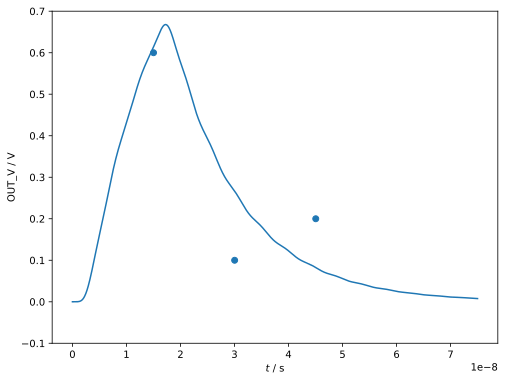

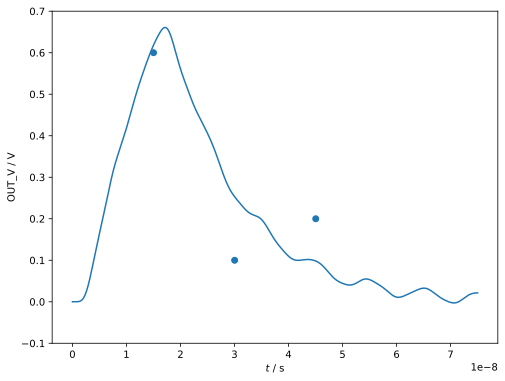

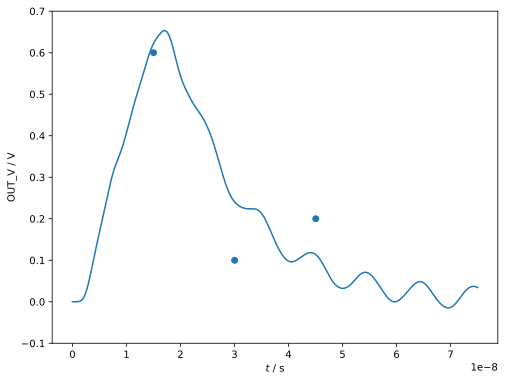

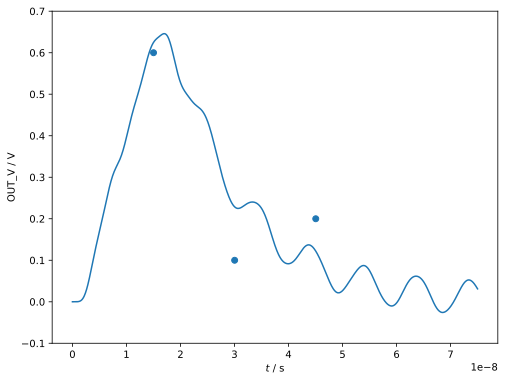

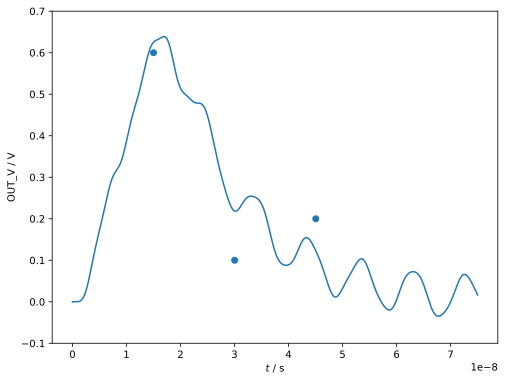

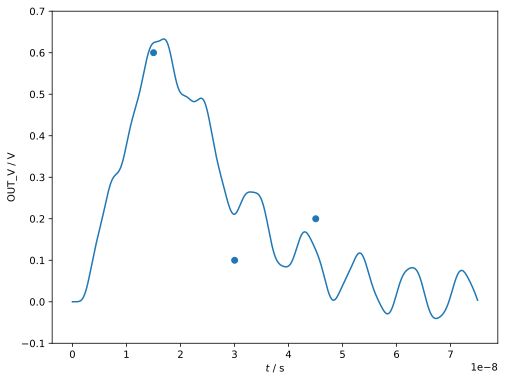

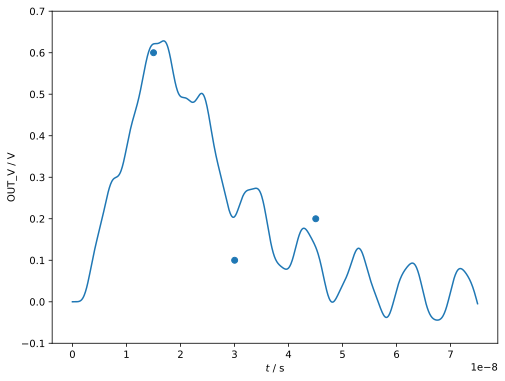

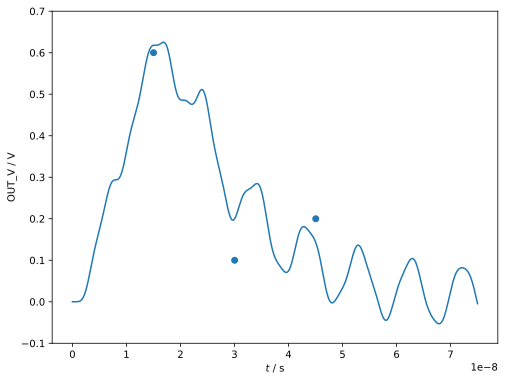

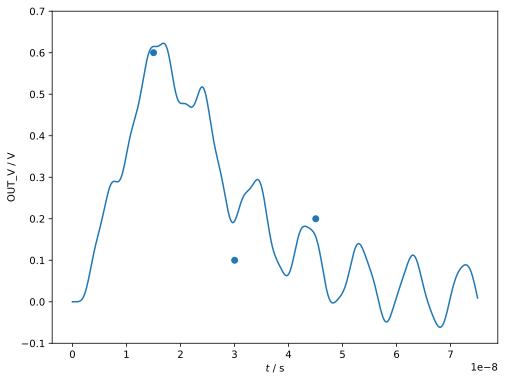

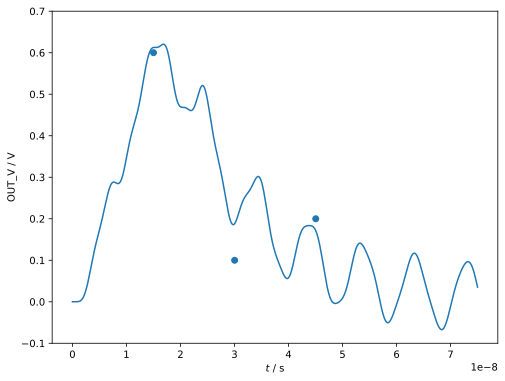

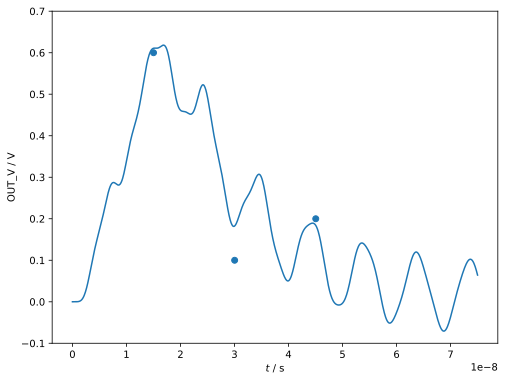

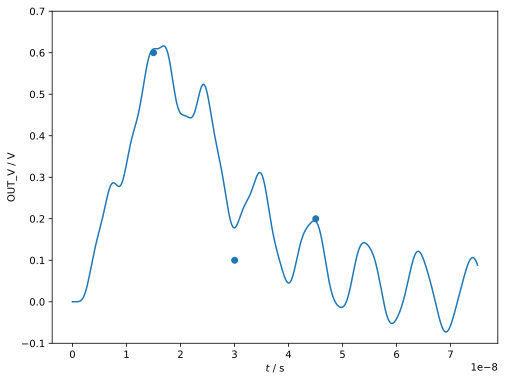

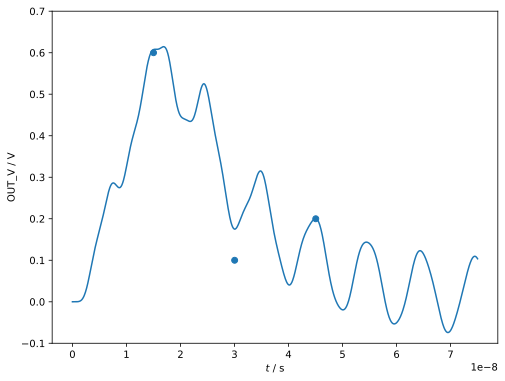

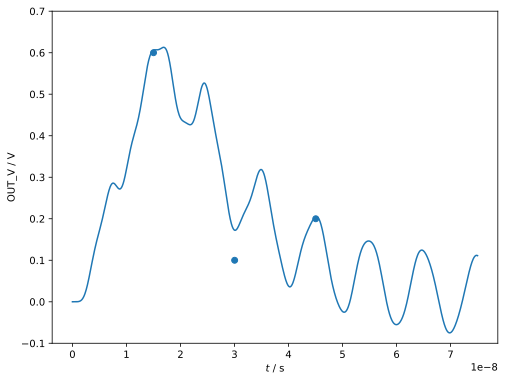

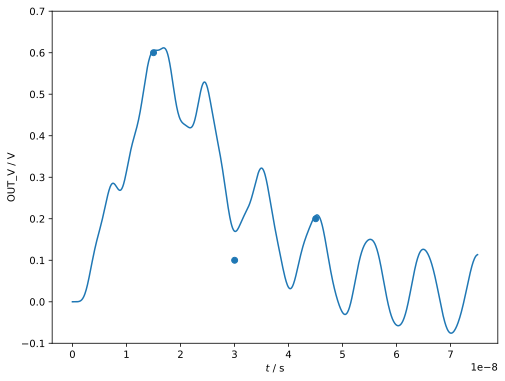

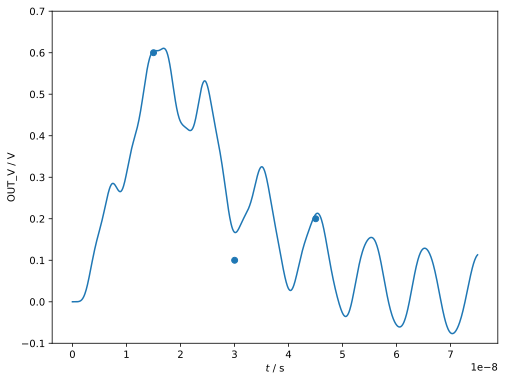

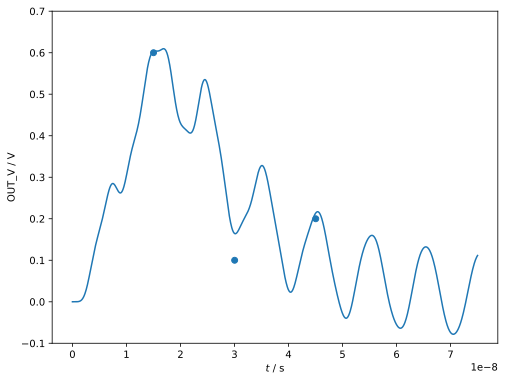

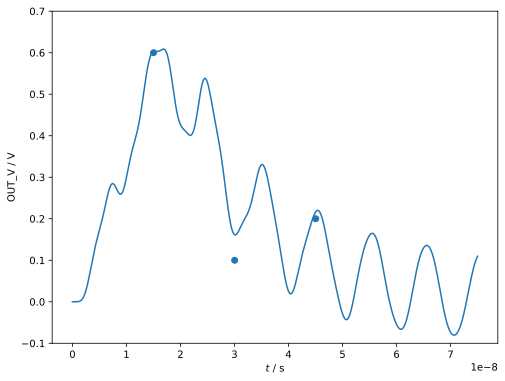

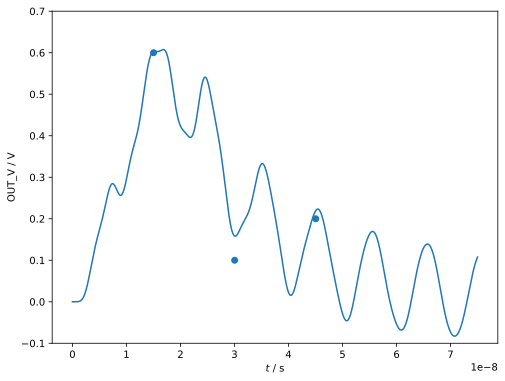

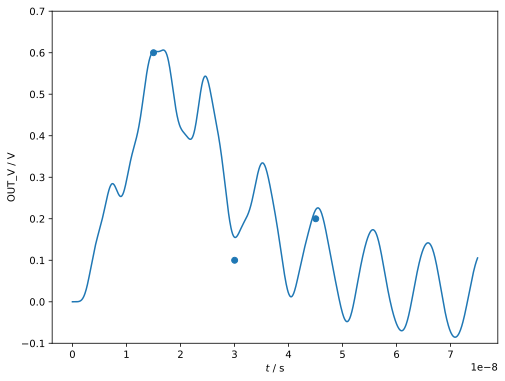

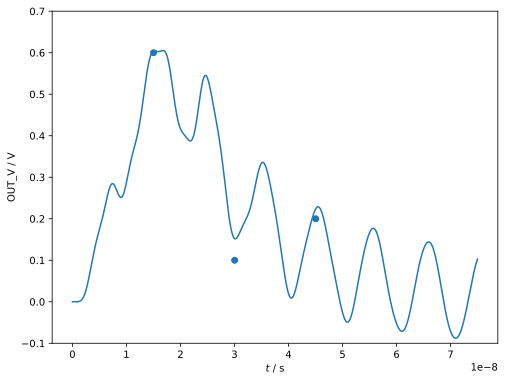

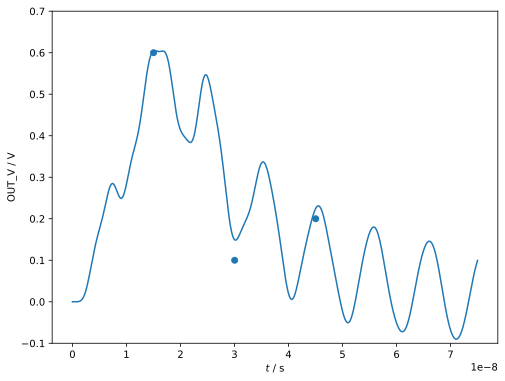

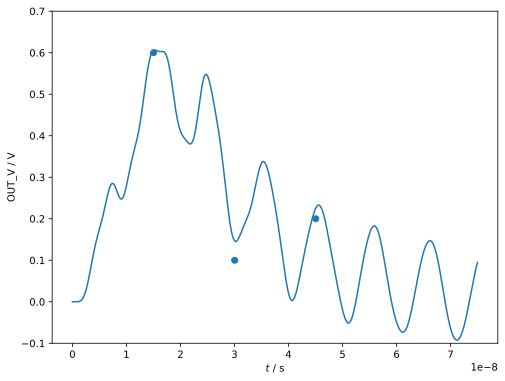

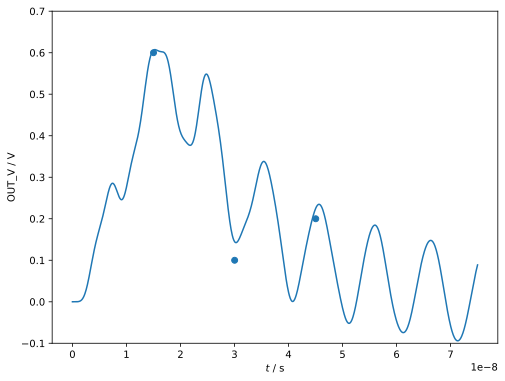

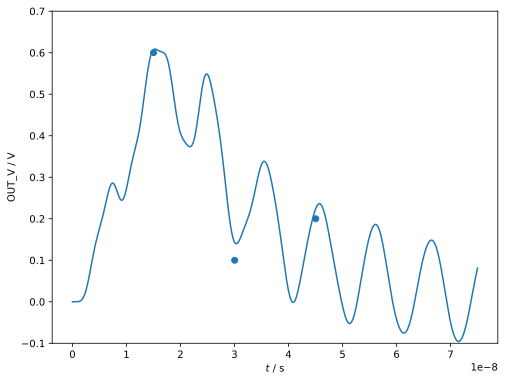

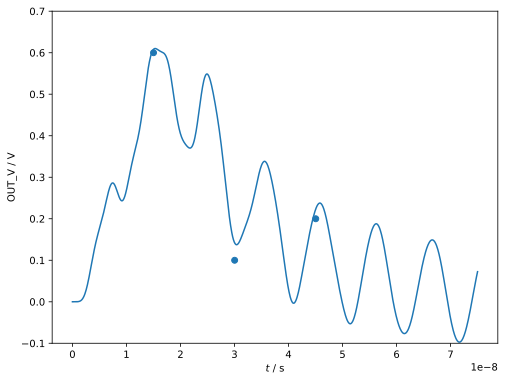

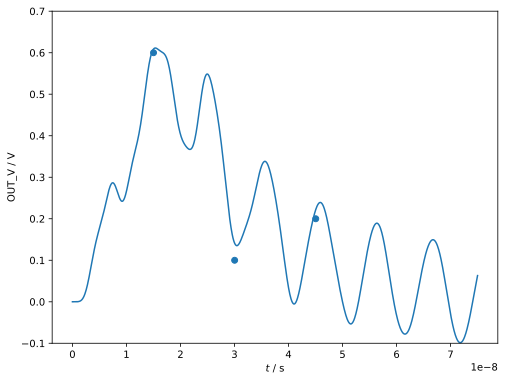

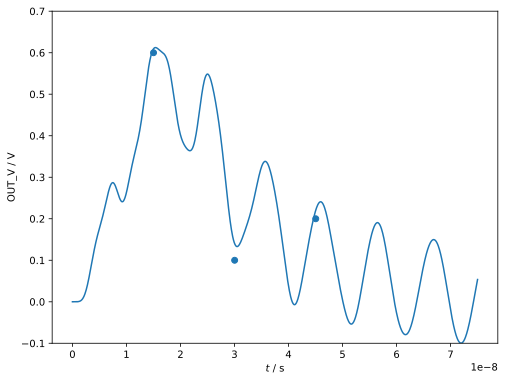

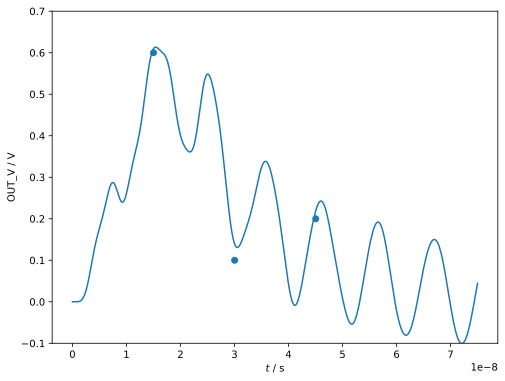

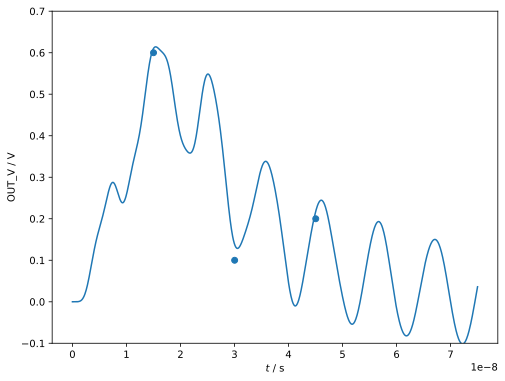

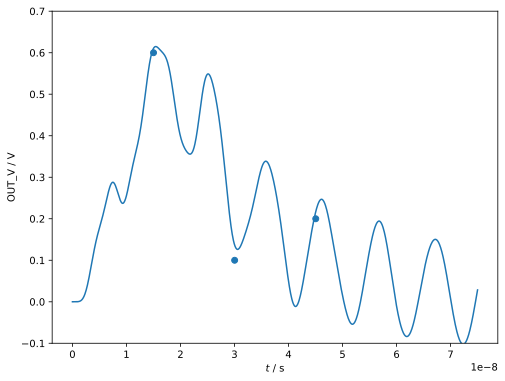

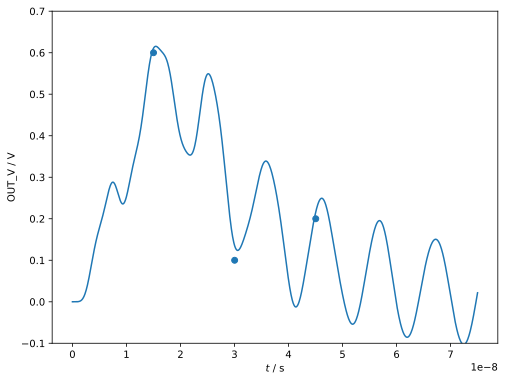

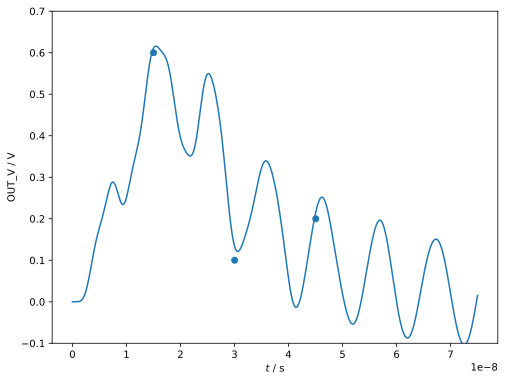

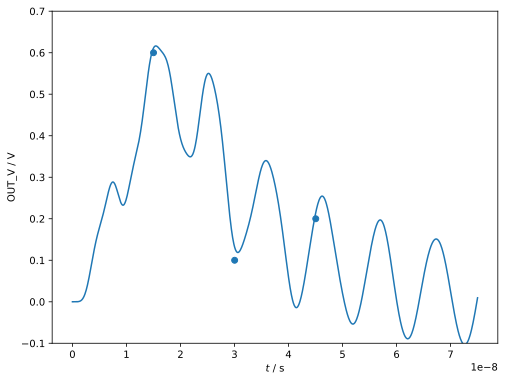

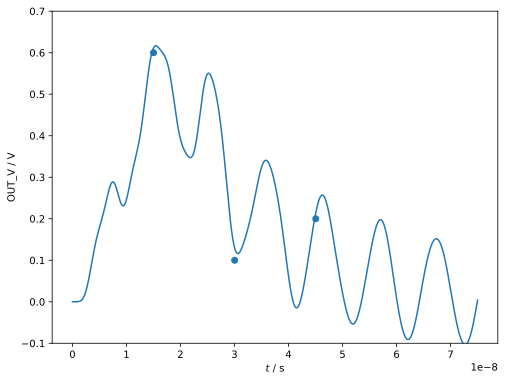

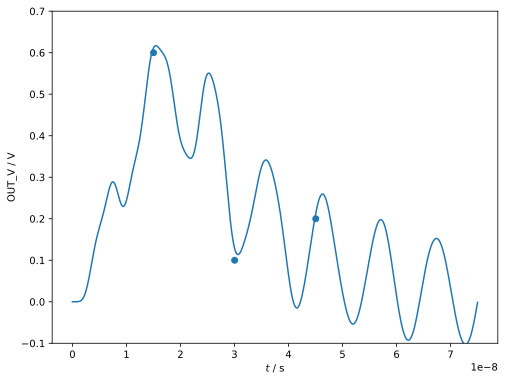

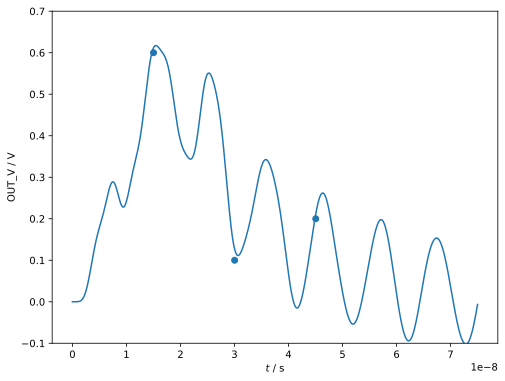

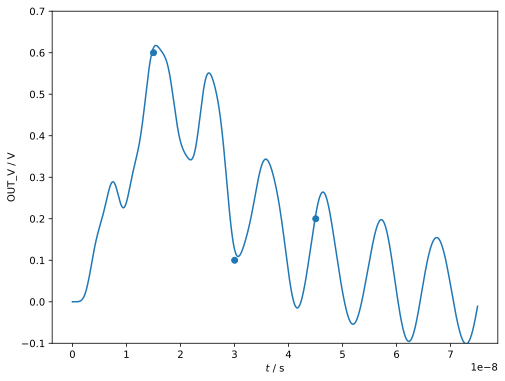

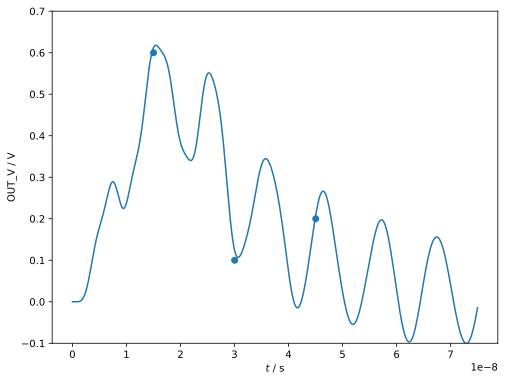

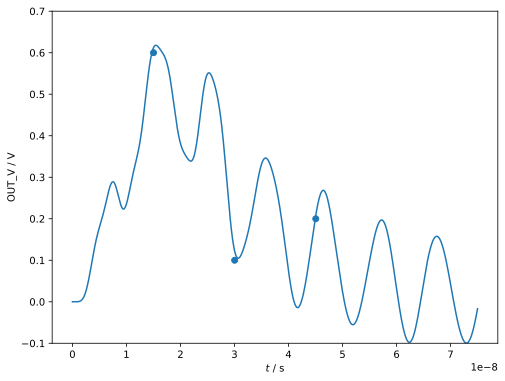

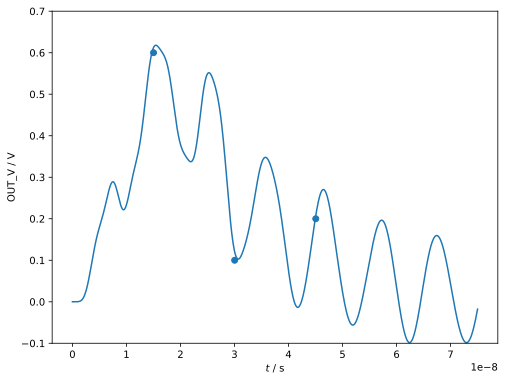

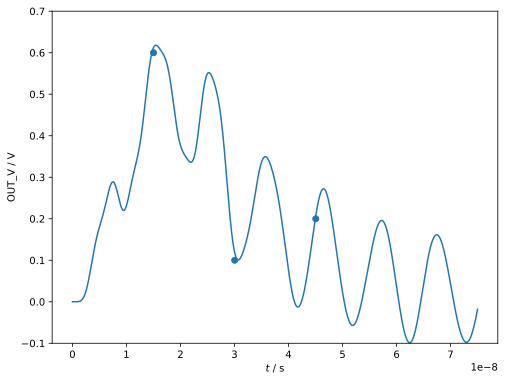

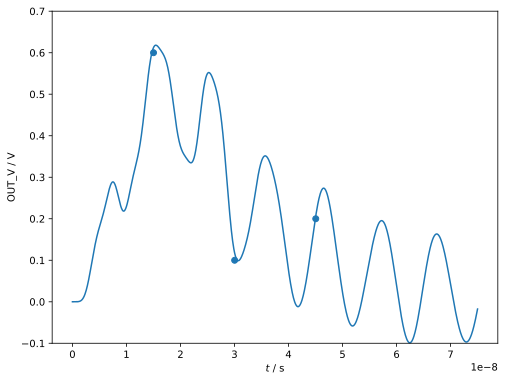

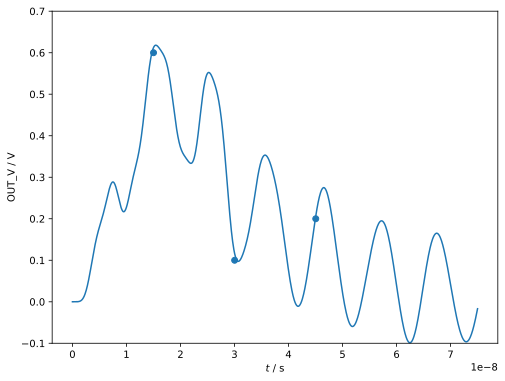

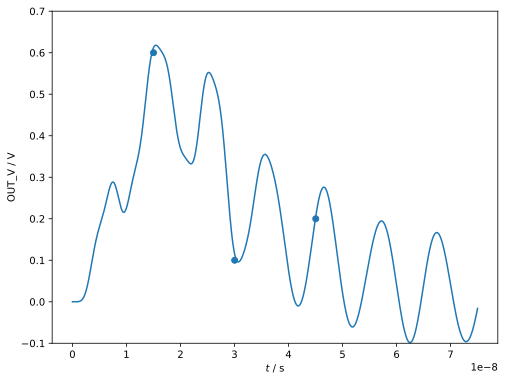

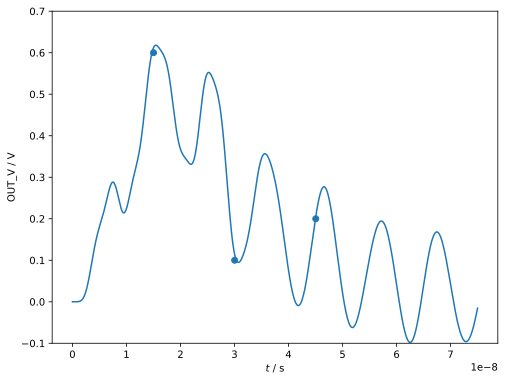

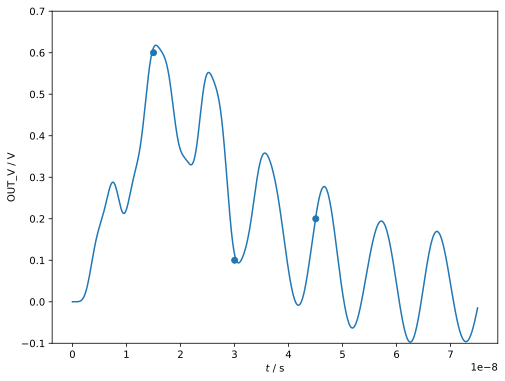

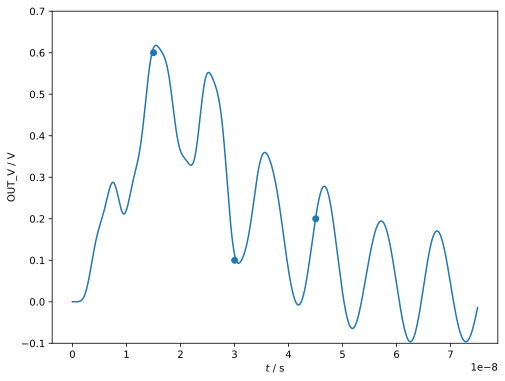

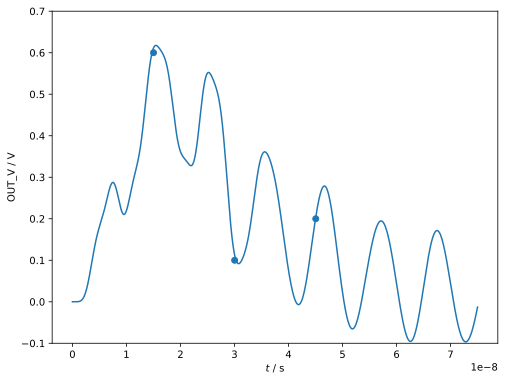

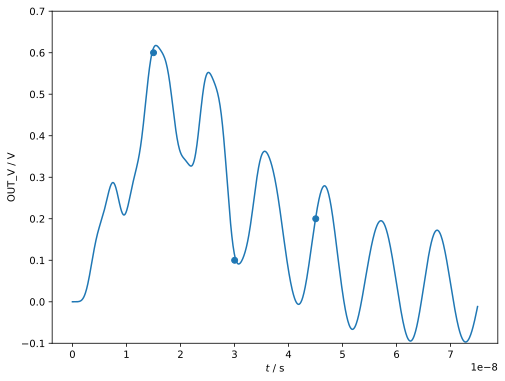

In [63]:
optimizer_state = optimizer.init(current_parameters)
for step in trange(50):
    # model_vals = model_all_ts(current_parameters)
    # model_grad = model_grad_fn(current_parameters)

    model_vals = model_all_ts(current_parameters)
    plt.plot(ts_space, model_vals[:, -1])
    plt.scatter([ts_space[t] for t in t_indices], goal_values)
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel('$t$ / s')
    plt.ylabel('OUT_V / V')
    plt.ylim(-0.1, 0.7)
    plt.savefig(f'step_{step}.png', dpi=300)
    plt.show()
    
    # plt.plot(ts_space, model_grad['MmE_26_ws'][:, -1])
    # Plot goal points
    # for i, (t, v, g) in enumerate(zip(ts_space, model_vals[:, -1], model_grad['MmE_26_ws'][:, -1])):
    #     if i % 10 == 0:
    #         plt.arrow(t, v, 0, g * 0.05, width=2e-10, head_length=0.02, lw=0)
    current_parameters, optimizer_state = step_parameters(current_parameters, optimizer_state)
    # print(current_parameters)


In [ ]:
def model_function(parameters: dict) -> jax.Array:
    """Produce the signal output of the model given a set of parameters."""
    solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=parameters, saveat=dr.SaveAt(ts=[3e-8,]))
    # Fetch the first timestep, and the first simulation variable (IN_V)
    return solution.ys[0][0]

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
display(model_function(parameters=initial_parameters))
display(initial_parameters)

In [82]:
model_grad = eqx.filter_jit(eqx.filter_grad(model_function))

@eqx.filter_jit
def loss_function(parameters: dict) -> jax.Array:
    """Gradients of the model function with respect to each parameter."""
    gradients = model_grad(parameters)
    return jnp.array(sum(gradients[key]**2 for key in gradients))

display(model_grad(initial_parameters))
loss_function(initial_parameters)

{'IN_V_c': Array(-4213675.71739767, dtype=float64, weak_type=True),
 'IN_V_g': Array(-0.22278218, dtype=float64, weak_type=True),
 'InpI_0_g': Array(-0.22278218, dtype=float64, weak_type=True),
 'MmE_0_ws': Array(0.23325088, dtype=float64, weak_type=True),
 'MmE_0_wt': Array(0.23325088, dtype=float64, weak_type=True),
 'MmE_1_ws': Array(-0.14454426, dtype=float64, weak_type=True),
 'MmE_1_wt': Array(-0.14454426, dtype=float64, weak_type=True),
 'MmE_2_ws': Array(0.10262688, dtype=float64, weak_type=True),
 'MmE_2_wt': Array(0.10262688, dtype=float64, weak_type=True),
 'MmE_3_ws': Array(0.00937667, dtype=float64, weak_type=True),
 'MmE_3_wt': Array(0.00937667, dtype=float64, weak_type=True),
 'MmE_4_ws': Array(0.00109299, dtype=float64, weak_type=True),
 'MmE_4_wt': Array(0.00109299, dtype=float64, weak_type=True),
 'MmE_5_ws': Array(0.05815849, dtype=float64, weak_type=True),
 'MmE_5_wt': Array(0.05815849, dtype=float64, weak_type=True),
 'MmE_6_wt': Array(-0.2290372, dtype=float64, we

Array(2.91912414e+16, dtype=float64, weak_type=True)

In [163]:
from optax import adam, OptState, apply_updates

optimizer = adam(learning_rate=3e-4)
optimizer_state = optimizer.init(initial_parameters)

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
@eqx.filter_jit
def step_single(parameters: dict, optimizer_state: OptState) -> tuple[jax.Array, dict, OptState]:
    loss_value, loss_gradients = eqx.filter_value_and_grad(loss_function)(parameters)
    updates, new_optimizer_state = optimizer.update(loss_gradients, optimizer_state)
    new_parameters = apply_updates(parameters, updates)
    return loss_value, new_parameters, new_optimizer_state

for i in range(100):
    loss_value, initial_parameters, optimizer_state = step_single(initial_parameters, optimizer_state)
    print(f'Loss at step {i}: {loss_value}')
    

Loss at step 0: 2.9191241432353236e+16
adjoint=DirectAdjoint()
Loss at step 1: 0.02775334152887066
Loss at step 2: 0.0035666705031322226
Loss at step 3: 0.0012102368747092165
Loss at step 4: 0.0005955002638573184
Loss at step 5: 0.0003558987743876827
Loss at step 6: 0.0002395073576477899
Loss at step 7: 0.00017453095954557575
Loss at step 8: 0.00013461898731350879
Loss at step 9: 0.00010833804467157806
Loss at step 10: 9.009724664856187e-05
Loss at step 11: 7.690556055240221e-05
Loss at step 12: 6.70465981528494e-05
Loss at step 13: 5.947841022356315e-05
Loss at step 14: 5.353858739372086e-05
Loss at step 15: 4.8789451470545115e-05
Loss at step 16: 4.493219859663202e-05
Loss at step 17: 4.1757024025425834e-05
Loss at step 18: 3.9112977142192065e-05
Loss at step 19: 3.6889105577281915e-05
Loss at step 20: 3.5002301645331646e-05
Loss at step 21: 3.3389258917695696e-05
Loss at step 22: 3.200102247838874e-05
Loss at step 23: 3.079921816110025e-05
Loss at step 24: 2.9753393773621486e-05
Los